#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
from pathlib import Path


# **Prepare datasets**

In [2]:
df_nusax_test = pd.read_csv(r'../../data/nusax/test.csv', header= None)
df_nusax_train = pd.read_csv(r'../../data/nusax/train.csv', header= None)
df_nusax_valid = pd.read_csv(r'../../data/nusax/valid.csv', header= None)

df_nusax = df_nusax_train.append(df_nusax_test, ignore_index=True)
df_nusax = df_nusax.append(df_nusax_valid, ignore_index=True)

df_nusax.columns = ['id','text','label']
df_nusa = df_nusax.drop(columns=['id'])

df_tambahan = df_nusa.drop(index=0)
df_tambahan.head()

C:\Users\Mothy\AppData\Local\Temp\ipykernel_8100\2252669819.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_nusax = df_nusax_train.append(df_nusax_test, ignore_index=True)
C:\Users\Mothy\AppData\Local\Temp\ipykernel_8100\2252669819.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_nusax = df_nusax.append(df_nusax_valid, ignore_index=True)


,text,label
1,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
2,Kue-kue yang disajikan bikin saya bernostalgia...,positive
3,Ibu pernah bekerja di grab indonesia,neutral
4,Paling suka banget makan siang di sini ayam sa...,positive
5,Pelayanan bus DAMRI sangat baik,positive


In [3]:
df_tugas= pd.read_csv(r'../../data/train_preprocess.tsv.txt', sep='\t', header=None)
df_tugas.columns =['text', 'label']
df_tugas.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df = df_tambahan.append(df_tugas, ignore_index=True)
df.drop(df.index[df['label'] == 'label'], inplace = True)
df.head()

C:\Users\Mothy\AppData\Local\Temp\ipykernel_8100\805886768.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_tambahan.append(df_tugas, ignore_index=True)


,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,Ibu pernah bekerja di grab indonesia,neutral
3,Paling suka banget makan siang di sini ayam sa...,positive
4,Pelayanan bus DAMRI sangat baik,positive


In [5]:
df.shape

(12000, 2)

In [6]:
df.columns =['text', 'label']
df

,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,Ibu pernah bekerja di grab indonesia,neutral
3,Paling suka banget makan siang di sini ayam sa...,positive
4,Pelayanan bus DAMRI sangat baik,positive
...,...,...
11997,tidak kecewa,positive
11998,enak rasa masakan nya apalagi kepiting yang me...,positive
11999,hormati partai-partai yang telah berkoalisi,neutral
12000,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

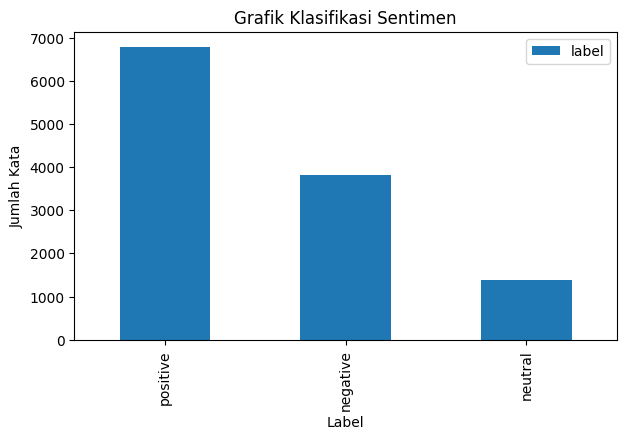

In [7]:
df["label"].value_counts().plot.bar(figsize=(7,4))
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()


In [8]:
df.label.value_counts()

positive    6794
negative    3819
neutral     1387
Name: label, dtype: int64

# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

alay_dict = pd.read_csv(r'../../data/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})

id_stopword_dict = pd.read_csv(r'../../data/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_emoji(text):
    subs = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text_emo = subs.sub(r'',text)
    return text_emo

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) 
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
    text = remove_emoji(text)
    text = normalize_alay(text) 
    text = stemming(text) 
    text = remove_stopword(text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mothy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mothy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
df['text_clean'] = df.text.apply(preprocess)

In [11]:
df.head()

,text,label,text_clean
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral,nikmat cicil 0 12 mesan tiket pesawat air asia...
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive,kue kue saji bikin nostalgia tipikal kue zaman...
2,Ibu pernah bekerja di grab indonesia,neutral,kerja grab indonesia
3,Paling suka banget makan siang di sini ayam sa...,positive,suka banget makan siang ayam sambal enak bange...
4,Pelayanan bus DAMRI sangat baik,positive,layan bus damri


In [12]:
#Save data csv to sql
import sqlite3

conn_sql = sqlite3.connect('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/databaru_tosql.db')
df.to_sql('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/databaru.txt', conn_sql, if_exists='replace', index=False)

conn_sql.close()

#Sortir Data Berdasarkan 3 Sentimen

In [13]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6794, Neu: 1387, Neg: 3819
Total data: 12000


#Feature Extraction

In [14]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [15]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [16]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (RNN)

In [17]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))
adam=optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,010,755
Trainable params: 10,010,755
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
960/960 [==============================] - 86s 88ms/step - loss: 0.5712 - accuracy: 0.7606 - val_loss: 0.4185 - val_accuracy: 0.8396
Epoch 2/10
960/960 [==============================] - 81s 85ms/step - loss: 0.2910 - accuracy: 0.8932 - val_loss: 0.4509 - val_accuracy: 0.8429
Epoch 2: early 

#Evaluation

In [18]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

75/75 [==============================] - 1s 5ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       770
           1       0.77      0.71      0.74       251
           2       0.84      0.95      0.90      1379

    accuracy                           0.84      2400
   macro avg       0.83      0.78      0.80      2400
weighted avg       0.84      0.84      0.84      2400



#Cross Validation

In [19]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(3, activation='softmax'))
    adam=optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
960/960 [==============================] - 82s 84ms/step - loss: 0.5908 - accuracy: 0.7535 - val_loss: 0.3965 - val_accuracy: 0.8425
Epoch 2/10
960/960 [==============================] - 80s 84ms/step - loss: 0.2873 - accuracy: 0.8970 - val_loss: 0.4179 - val_accuracy: 0.8537
Epoch 2: early stopping
75/75 [==============================] - 1s 5ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       770
           1       0.72      0.78      0.75       251
           2       0.88      0.93      0.91      1379

    accuracy                           0.85      2400
   macro avg       0.82      0.82      0.81      2400
weighted avg       0.85      0.85      0.85      2400

Epoch 1/10
960/960 [==============================] - 82s 84ms/step - loss: 0.6106 - accuracy: 0.7425 - val_loss: 0.4026 - val_accuracy: 0.8462
Epoch 2/10
960/960 [==============================] - 80s 84ms/step - loss: 0.2874 - accuracy: 

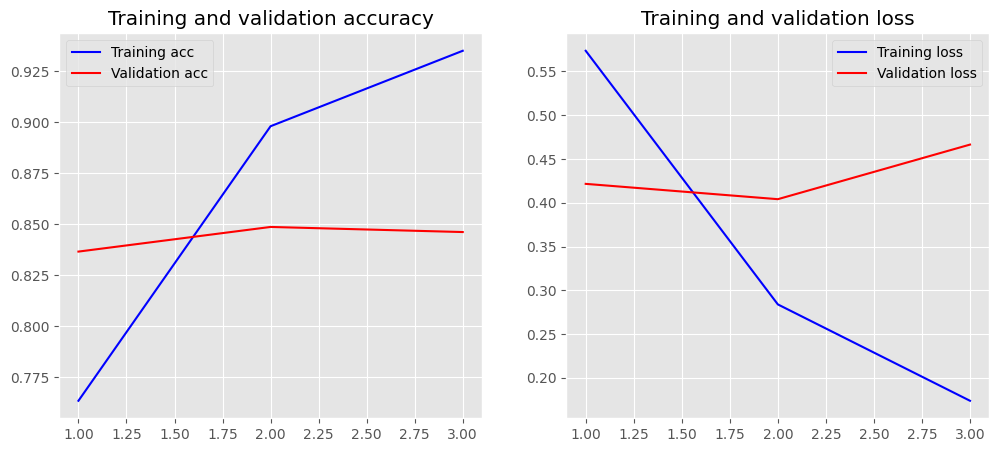

In [20]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)
 
  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

75/75 [==============================] - 0s 6ms/step
[[ 622   38  110]
 [  65  165   21]
 [ 123   12 1244]]


75/75 [==============================] - 0s 6ms/step


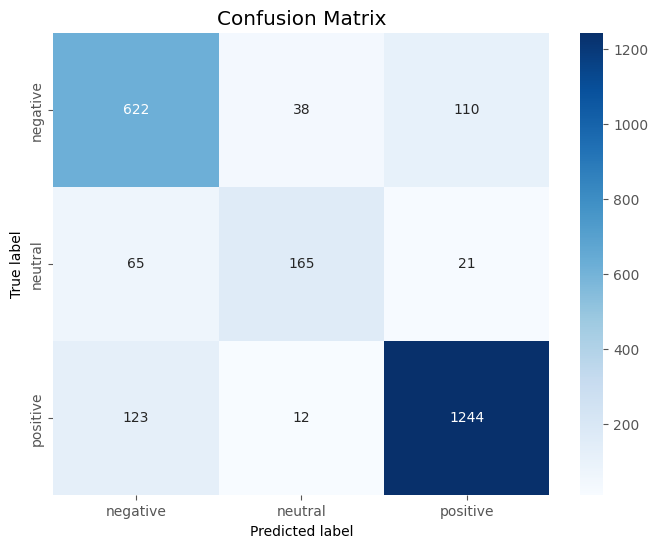

In [22]:
from sklearn.metrics import confusion_matrix

labels = ['negative', 'neutral', 'positive']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# # Flatten the arrays if needed
y_pred = y_pred.ravel()
y_test = y_test.ravel()

cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#Export Model

In [23]:
model.save('model_rnn.h5')
print('Model has created!')

Model has created!


#Testing Model

In [24]:
input_text = """ 
Amin, smg selalu di lancarkan n di mudahkan rejeki nya..
"""

sentiment = ['negative', 'neutral', 'positive']

text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_rnn.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 185ms/step
Text:  amin moga lancar mudah rejeki nya
Sentiment:  positive
